# Parsing HRV data

In [4]:
import pandas as pd
import os, glob

path = os.path.join(os.getcwd(),"..\HRV")
csv_files = glob.glob(os.path.join(path, "*.xlsx"))

all_clients = {}

for f in csv_files:

    df = pd.read_excel(f, header=None, names=["param","value"])
    
    file_name = f.split("\\")[-1].split("_")
    client_id = file_name[0]
    
    if client_id not in all_clients:
        all_clients[client_id] = {}
        
    all_clients[client_id][file_name[1].split(".")[0]] = df
    
madad = ["RSA", "Mean IBI", "SDNN","AVNN","RMSSD","NN50","pNN50"]

final_df_hrv = pd.DataFrame()


all_client_dfs = []

for client_id in all_clients:
    columns = []
    data = []
    #print("Client id: ", client_id)
    for data_type in all_clients[client_id]:
        #print("Data type: ", data_type)
        for m in madad:
            columns.append(data_type + "_" + m)
            v = all_clients[client_id][data_type].loc[all_clients[client_id][data_type]["param"]==m]["value"]
            data.append(v.values[0])

    client_df = pd.DataFrame(columns=columns)
    client_df.loc[int(client_id)] = data
    all_client_dfs.append( client_df)
    
final_df_hrv = pd.concat(all_client_dfs)

final_df_hrv = final_df_hrv.sort_index(axis = 0)

final_df_hrv.to_excel("HRV.xlsx")  

print("Finished, look at your HRV excel file...")

Finished, look at your HRV excel file...


# Parsing GSC Data

In [6]:
import pandas as pd
import os, glob

path = os.path.join(os.getcwd(),"..\GSC")
csv_files = glob.glob(os.path.join(path, "*.xlsx"))

all_clients = {}

for f in csv_files:

    df = pd.read_excel(f, header=None, names=["param","value"])
    
    file_name = f.split("\\")[-1].split("_")
    client_id = file_name[2]
    
    if client_id not in all_clients:
        all_clients[client_id] = {}
        
    all_clients[client_id][file_name[1]] = df
    
madad = ["Total SCRs","ER-SCRs","NS-SCRs","Tonic SCL","Mean SC","Tonic Period"]

final_df_gsc = pd.DataFrame()


all_client_dfs = []

for client_id in all_clients:
    columns = []
    data = []
    #print("Client id: ", client_id)
    for data_type in all_clients[client_id]:
        #print("Data type: ", data_type)
        for m in madad:
            #print("Madad: ",m)
            columns.append(data_type + "_" + m)
            v = all_clients[client_id][data_type].loc[all_clients[client_id][data_type]["param"]==m]["value"]
            data.append(v.values[0])

    client_df = pd.DataFrame(columns=columns)
    client_df.loc[int(client_id)] = data
    all_client_dfs.append( client_df)
    
final_df_gsc = pd.concat(all_client_dfs)

final_df_gsc = final_df_gsc.sort_index(axis = 0)

final_df_gsc.to_excel("GSC.xlsx")  

print("Finished, look at your GSC excel file...")

Finished, look at your GSC excel file...


### Found data mismatch between DB, HRV,GSC

In [15]:
db_df = pd.read_excel("DB.xlsx")

print("Subjects in DB", len(db_df), "Subjects in GSC stats",len(final_df_gsc), "Subjects in HRV stats",len(final_df_hrv))

a = set(db_df["ID"].tolist())
b = set(final_df_gsc.index.tolist())
c = set(final_df_hrv.index.tolist())

diff = (a | b | c) - (a & b & c)
print("Subjects that doesn't have all the data: ",diff)
for d in diff:
    if d not in a:
        print(d, "Missing in DB")
    if d not in b:
        print(d, "Missing in GSC")
    if d not in c:
        print(d, "Missing in HRV")


Subjects in DB 53 Subjects in GSC stats 49 Subjects in HRV stats 51
Subjects that doesn't have all the data:  {346, 308, 317, 327}
346 Missing in GSC
346 Missing in HRV
308 Missing in GSC
317 Missing in GSC
317 Missing in HRV
327 Missing in GSC


# Merging HRV and GSC to the DB

In [16]:
db_df = db_df.set_index("ID")

db_df = db_df.merge(final_df_gsc, how='left', left_index=True, right_index=True)
db_df = db_df.merge(final_df_hrv, how='left',left_index=True, right_index=True)

db_df.to_excel("Merged_DB.xlsx")  

# Experiments with linear regression

In [25]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression

all_cors_dfs = []
def get_highly_correlated(df, features, threshold=0.7):
    """Prints highly correlated features pairs in the data frame (helpful for feature engineering)"""
    corr_df = df[features].corr(method='pearson') # get correlations
    correlated_features = np.where(np.abs(corr_df) >= threshold) # select ones above the abs threshold
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value

    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        for v, i, j in s_corr_list:
            cols = df[features].columns
            cor_df = pd.DataFrame([[corr_df.index[i], corr_df.columns[j], v]],columns=["X","Y","V"])
            all_cors_dfs.append(cor_df)

all_corrs = pd.DataFrame()
get_highly_correlated(db_df, db_df.columns)
all_corrs = pd.concat(all_cors_dfs,ignore_index=False)

print(all_corrs)

all_corrs.to_excel("Correlations.xlsx")  


                  X                 Y         V
0     base_Mean IBI         base_AVNN  1.000000
0      sim_Mean IBI          sim_AVNN  1.000000
0      S_Total SCRs         S_NS-SCRs  0.999920
0      B_Total SCRs         B_NS-SCRs  0.999488
0       B_Tonic SCL         B_Mean SC  0.998697
0       S_Tonic SCL         S_Mean SC  0.997147
0          sim_NN50         sim_pNN50  0.985172
0         B_Mean SC         S_Mean SC  0.957794
0       B_Tonic SCL         S_Mean SC  0.955307
0         sim_RMSSD          sim_NN50  0.949403
0         base_NN50        base_pNN50  0.948033
0        base_RMSSD        base_pNN50  0.946755
0         sim_RMSSD         sim_pNN50  0.945064
0         B_Mean SC       S_Tonic SCL  0.942479
0       B_Tonic SCL       S_Tonic SCL  0.940395
0     base_Mean IBI      sim_Mean IBI  0.891304
0     base_Mean IBI          sim_AVNN  0.891304
0         base_AVNN      sim_Mean IBI  0.891304
0         base_AVNN          sim_AVNN  0.891304
0        base_RMSSD         base_NN50  0

<AxesSubplot:>

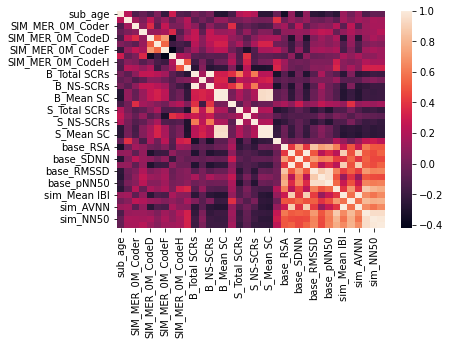

In [26]:
import seaborn as sns
sns.heatmap(db_df.corr(method='pearson'))

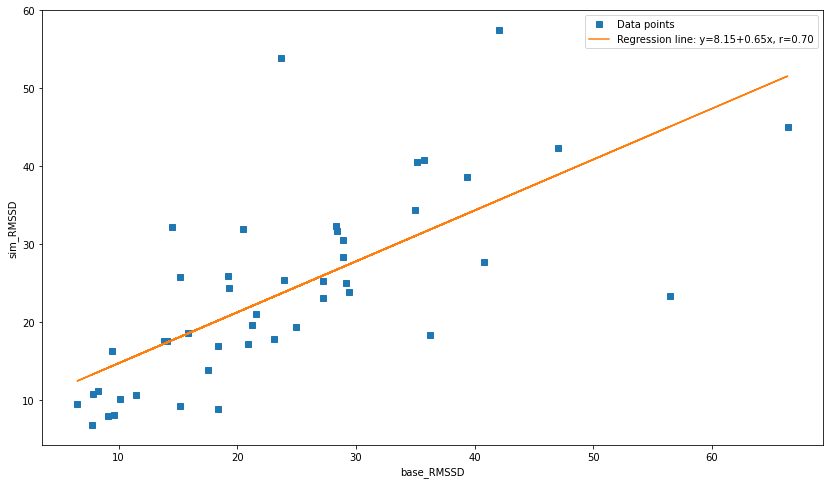

In [35]:
# creating X-Y Plots With a Regression Line
import scipy
from numpy import mean
from numpy import std
from matplotlib import pyplot

# slope, intersept, and correlation coefficient calculation 
col1 = all_corrs.iloc[-1]["X"]
col2 = all_corrs.iloc[-1]["Y"]


# Remove NANs
mask = ~np.isnan(db_df[col1]) & ~np.isnan(db_df[col2])

slope, intercept, r, p, stderr = scipy.stats.linregress(db_df[col1][mask], db_df[col2][mask])

line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

# plotting
fig, ax = pyplot.subplots(figsize = (14,8))
ax.plot(db_df[col1], db_df[col2], linewidth=0, marker='s', label='Data points')
ax.plot(db_df[col1], intercept + slope * db_df[col1], label=line)
ax.set_xlabel(col1)
ax.set_ylabel(col2)
ax.legend(facecolor='white')
pyplot.show()